Trying very simple vector addition on the GPU in a simple scenario using OpenCL (pyopencl). This is also a basic intro to OpenCL I guess, at a high level at least. 

In [1]:
import pyopencl as cl
import numpy as np
import time
import matplotlib.pyplot as plt

Platform: A particular implementation of OpenCL. <br/><br/>
Context: Basically a runtime environment for kernels -- think of what web container is for servlets in Java.<br/> &emsp;&emsp;&emsp;&emsp;You can have multiple devices within a context, which implies that you can use multiple devices to execute your kernel. <br/><br/>
Device: Pretty self-explanatory. <br><br>
Evidently, it makes sense to provide the platform and devices you are going to use to define the context. 


In [2]:
# In jupyter, this automatically chooses a platform and a device. If you ran this code in a normal
# python file and executed in the terminal, it'd ask you to choose the platform and devices interactively.
# You can also set an environment variable to choose the platform and devices. When you run this code in 
# a normal python file in a terminal and choose the platform and device/s, pyopencl will actually tell you
# the particular environment variable to set in order to avoid the choosing. Try. 
# https://documen.tician.de/pyopencl/runtime_platform.html#pyopencl.create_some_context to understand more 
# about this function. 
ctx = cl.create_some_context()
ctx

<pyopencl.Context at 0x55cc88621758 on <pyopencl.Device 'AMD Radeon RX Graphics (polaris11, LLVM 15.0.7, DRM 3.54, 6.5.0-14-generic)' on 'Clover' at 0x55cc886b1e88>>

A command queue is a queue that contains the commands that tell the OpenCL device (like a GPU) what to do. <br>
The "what to do" could be kernel execution, memory operations, etc. You could say that the "context" does its job <br>
through the command queue. Btw, each command-queue points to a single device within a context.

In [3]:
# pyopencl automatically chooeses a device for the command-queue if not explicitely given.
# I have only chosen one device above, so I don't have to worry about choosing a specific one. 
queue = cl.CommandQueue(ctx)

Writing the kernel and "building" it (compiling) for the given context. I guess depending upon the platform and<br>
devices, the compilation can be different, so it makes sense to pass the context. <br><br>

* <i>each_WI_add</i> = the number of additions each work item will do.<br>
* <i>gid</i> = global id of the work item that is executing the kernel. goes from 0 to number_of_work_items - 1. <br>
      Actually, the arrangement of work items can be multi-dimensional, so technically, "get_global_id(0)" <br>
      gives you the id along the "x" direction. Here, we are working with a 1D array, so we don't have to worry <br>
      about that stuff. <br><br>


You have info like global id, local id, etc, and given these info, you have to cleverly write the kernel. <br>
You can read this: https://public.websites.umich.edu/~smeyer/cuda/Preso07-OpenCL.pdf to understand more about <br>
OpenCL programming. One of the interesting parts is to figure out the proper indices of your result array (in order to <br>
properly store the results) using the ids of workgroups, work items, your knowledge about how many workgroups and <br>
work items there are, how the input and result arrays are structured, etc. 

In [4]:
krnl_str = """ __kernel void vec_add(__global int *res, __global const int *first, __global const int *second, int size){
    int gid = get_global_id(0);
    int each_WI_add = size/get_global_size(0);
    int idx = gid * each_WI_add; 
    for(int i = idx; i < idx + each_WI_add; ++i){
        res[i] = first[i] + second[i];
    }
}
"""
krnl_prog = cl.Program(ctx, krnl_str).build()

Here, we'll define the arguments for our kernel in the host, and then create buffers and copy from host to device. 

In [5]:
mf = cl.mem_flags # To access flags. 

size = 64

first_host = np.int32(np.ones(size))
first_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=first_host)

second_host = np.int32(np.ones(size))
second_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=second_host)

result = cl.Buffer(ctx, mf.WRITE_ONLY, first_host.nbytes)

Here, we are actually executing the kernel. We are trying different numbers of work-items to see speeds in different situations. What we find is that the computations using more work-items is actually slower. It is probably because the thing we are computing in the kernel is very simple. The overhead in parallelization i.e. sending the kernels to different processing elements instead of executing in a single one, actually is pretty significant here. <br><br>

If you forget pyopencl/opencl specifics, you can look things up. Hint: GPT, docs, google, etc.

In [6]:
times = []
sizes = [64, 32, 16, 8, 4, 2, 1] # The global sizes that we are experimenting with.
                                 # We are only using one workgroup. 

krnl_obj = krnl_prog.vec_add  # You execute the kernel through the kernel object 
                              # in pyopencl (at least one of the ways to do it.)

for sz in sizes:
    start_time = time.time()
    
    krnl_obj(queue, (sz,), (sz,), result, first_device, second_device, np.int32(size)) # start execution.
    queue.finish() # blocks further execution until all the commands in the queue are completed. 
    
    end_time = time.time()
    
    """
    # if you want to check whether the kernel is doing what it is supposed to. 
    res_np = np.empty_like(first_host)
    cl.enqueue_copy(queue, res_np, result)
    print(res_np)
    """
    
    times.append(end_time - start_time)
    
print(times)

[0.00164031982421875, 0.0001971721649169922, 0.0001404285430908203, 0.0001773834228515625, 0.0001494884490966797, 0.0001468658447265625, 0.0001533031463623047]


Let's also graph things! As you can see clearly, increasing work-items is actually slower in the case of simple vector addition. To not make things complicated, I used only vectors of size 64 (the number of processing elements in a single compute unit in my GPU), and worked with only one workgroup. Also the computation in the kernel is evidently very simple. In cases where the size of the matrix/vector is large, it is multidimensional, the computations are costly, etc, the overhead in parallelization would probably be insignificant. I will perhaps try something like matmul next time to really see the power of accelerators. 

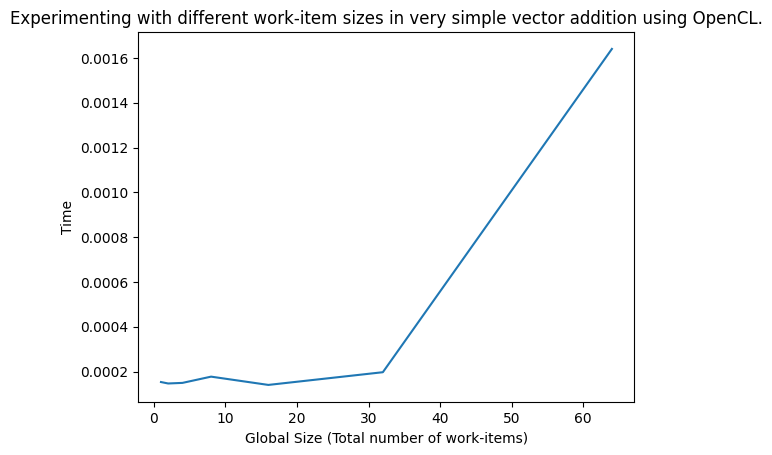

In [7]:
plt.plot(sizes, times)

plt.xlabel('Global Size (Total number of work-items)')
plt.ylabel('Time')

plt.title('Experimenting with different work-item sizes in very simple vector addition using OpenCL.')

plt.show()